In [1]:
import numpy as np
import tensorflow as tf
from mistune.toc import render_toc_ul
from tensorflow.keras import layers, models
from sklearn.model_selection import GroupShuffleSplit, train_test_split, GroupKFold
import matplotlib.pyplot as plt
from tensorflow.lite.python.schema_py_generated import Tensor

2025-10-30 20:02:46.766889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 20:02:47.496359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 20:02:50.130625: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# -----------------------
# 1) Load data
# -----------------------
loaded = np.load("vitaldb_ecgii_stft.npz", allow_pickle=True)

In [3]:
# S: np.ndarray, shape (N, F, T)  # STFT (log-magnitude, normalized per beat)
# Y: np.ndarray, shape (N, 3)     # columns e.g. ['MAP', 'SPO2', 'ETCO2'] with NaNs where missing
# f: np.ndarray, shape (F,)       # frequency axis (Hz)
# t: np.ndarray, shape (T,)       # time axis (s), centered (0 ~ R-peak)
# y_cols: list[str]               # e.g. ['MAP','SPO2','ETCO2']
# beat_caseids: np.ndarray, shape (N,)  # optional; for group (patient) split
list(loaded.keys())

['S', 'Y', 'f', 't', 'y_cols', 'beat_caseids']

In [4]:
S = loaded["S"]          # (N, F, T)
Y = loaded["Y"]          # (N, 3)
f = loaded["f"]          # (F,)
t = loaded["t"]          # (T,)
beat_caseids = loaded["beat_caseids"]  # (N,)
y_cols = loaded["y_cols"]  # list of target names

In [5]:
print("Shapes:", S.shape, Y.shape, f.shape, t.shape, beat_caseids.shape, len(y_cols))

Shapes: (103188, 58, 17) (103188, 3) (58,) (17,) (103188,) 3


In [6]:
# code to check if NaN are present in S, Y, f, t, beat_caseids, y_cols
print("NaNs in S:", np.isnan(S).any())
print("NaNs in Y:", np.isnan(Y).any())
print("NaNs in f:", np.isnan(f).any())
print("NaNs in t:", np.isnan(t).any())
print("NaNs in beat_caseids:", np.isnan(beat_caseids).any())
print("NaNs in y_cols:", any(col is None for col in y_cols))

NaNs in S: False
NaNs in Y: True
NaNs in f: False
NaNs in t: False
NaNs in beat_caseids: False
NaNs in y_cols: False


In [7]:
# count number of NaNs in Y
nan_counts = np.isnan(Y).sum(axis=0)
for col, count in zip(y_cols, nan_counts):
    print(f"NaNs in {col}: {count}")

NaNs in MAP: 1538
NaNs in SPO2: 101426
NaNs in ETCO2: 102755


In [8]:
N, F, T = S.shape
X = S[..., None]  # channels_last -> (N, F, T, 1)

# split (grouped by case if available)
idx = np.arange(N)
if beat_caseids is not None:
    gkf = GroupKFold(n_splits=5)
    tr_idx, te_idx = next(gkf.split(idx, groups=beat_caseids))
    gkf2 = GroupKFold(n_splits=5)
    tr_core, va_idx = next(gkf2.split(tr_idx, groups=beat_caseids[tr_idx]))
    tr_idx = tr_idx[tr_core]
else:
    tr_idx, te_idx = train_test_split(idx, test_size=0.2, random_state=42)
    tr_idx, va_idx = train_test_split(tr_idx, test_size=0.2, random_state=42)

X_tr, X_va, X_te = X[tr_idx], X[va_idx], X[te_idx]
Y_tr, Y_va, Y_te = Y[tr_idx], Y[va_idx], Y[te_idx]

# per-target normalization on training set (ignore NaNs)
y_mean = np.nanmean(Y_tr, axis=0)
y_std  = np.nanstd (Y_tr, axis=0) + 1e-8
def norm_y(a):  return (a - y_mean) / y_std
def denorm_y(a): return a * y_std + y_mean

Y_tr_n = norm_y(Y_tr); Y_va_n = norm_y(Y_va); Y_te_n = norm_y(Y_te)

# ---------- tf.data datasets ----------
def make_ds(X, Y, bs=256, shuffle=False):
    # Keep NaNs in Y; our loss will mask them.
    ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), Y.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(min(len(X), 10000), seed=42)
    ds = ds.batch(bs).prefetch(tf.data.AUTOTUNE)
    return ds

ds_tr = make_ds(X_tr, Y_tr_n, shuffle=True)
ds_va = make_ds(X_va, Y_va_n)
ds_te = make_ds(X_te, Y_te_n)

I0000 00:00:1761825786.678648  132252 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
# ---------- masked MAE loss ----------
@tf.function
def masked_mae(y_true, y_pred):
    # mask: True where finite labels exist
    mask = tf.math.is_finite(y_true)
    y_true_clean = tf.where(mask, y_true, 0.0)
    abs_err = tf.abs(y_pred - y_true_clean) * tf.cast(mask, tf.float32)
    denom = tf.reduce_sum(tf.cast(mask, tf.float32)) + 1e-6
    return tf.reduce_sum(abs_err) / denom

# optional per-target masked MAE metric (reports in z-units)
def make_masked_mae_k(k):
    @tf.function
    def m(y_true, y_pred):
        yt = y_true[..., k:k+1]; yp = y_pred[..., k:k+1]
        mask = tf.math.is_finite(yt)
        yt = tf.where(mask, yt, 0.0)
        err = tf.abs(yp - yt) * tf.cast(mask, tf.float32)
        denom = tf.reduce_sum(tf.cast(mask, tf.float32)) + 1e-6
        return tf.reduce_sum(err) / denom
    return m

In [10]:
# ---------- model ----------
from tensorflow.keras import layers, models
def model1():
    inputs = layers.Input(shape=(F, T, 1))
    x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(3)(x)  # 3 targets (z-normalized)

    model = models.Model(inputs, outputs)
    model.summary()
    return model

In [11]:
# ---------- train ----------
ckpt = tf.keras.callbacks.ModelCheckpoint("best_spec_cnn.keras", monitor="val_loss",
                                        save_best_only=True, mode="min", verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model = model1()
model.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
        loss=masked_mae,
        metrics=[make_masked_mae_k(0), make_masked_mae_k(1), make_masked_mae_k(2)]
    )
hist = model.fit(ds_tr, validation_data=ds_va, epochs=25, callbacks=[ckpt, es])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 58, 17, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 58, 17, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 17, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 17, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 8, 96)      │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,411 (333.64 KB)

 Trainable params: 85,251 (333.01 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/25


2025-10-30 20:03:14.682018: I external/local_xla/xla/service/service.cc:163] XLA service 0x77bc7c0061a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 20:03:14.682801: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-30 20:03:14.821989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 20:03:15.184793: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-30 20:03:15.263222: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:03:15.

 14/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.7782 - m: 0.7853 - m_1: 0.3489 - m_2: 0.0715

I0000 00:00:1761825800.064892  132475 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


259/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5988 - m: 0.6022 - m_1: 0.3365 - m_2: 0.2256

2025-10-30 20:03:23.205077: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:03:23.205166: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:03:23.205176: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:03:23.942183: I external/l

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5986 - m: 0.6020 - m_1: 0.3369 - m_2: 0.2264

2025-10-30 20:03:27.562552: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.



Epoch 1: val_loss improved from None to 0.72205, saving model to best_spec_cnn.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.5806 - m: 0.5837 - m_1: 0.3691 - m_2: 0.2962 - val_loss: 0.7220 - val_m: 0.7380 - val_m_1: 0.3396 - val_m_2: 0.1666
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5313 - m: 0.5339 - m_1: 0.2739 - m_2: 0.2290
Epoch 2: val_loss improved from 0.72205 to 0.62967, saving model to best_spec_cnn.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5304 - m: 0.5331 - m_1: 0.3226 - m_2: 0.2670 - val_loss: 0.6297 - val_m: 0.6567 - val_m_1: 0.1145 - val_m_2: 0.1742
Epoch 3/25
257/262 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4987 - m: 0.5010 - m_1: 0.2465 - m_2: 0.3089
Epoch 3: val_loss did not improve from 0.62967
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5069 - m: 0.5094 - m_1: 0.3133 - m_2: 0.3150 - val_loss: 0.6592 - val_m: 0.6956 - val_m_1: 0.1181 - val_m_2: 0.1756
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

In [12]:
def compute_per_target_orig(eval_dict, y_std, metric_base='m'):
    """
    Extract per-target z-mae metrics from eval_dict and return denormalized MAE array.
    eval_dict: dict returned by model.evaluate(..., return_dict=True)
    y_std: 1D array-like of per-target std used for normalization
    """
    items = []
    for k, v in eval_dict.items():
        if k == metric_base:
            items.append((0, float(v)))
        elif k.startswith(metric_base + '_'):
            try:
                idx = int(k.split('_', 1)[1])
                items.append((idx, float(v)))
            except Exception:
                continue
    if not items:
        raise ValueError(r"No per-target metrics found in eval_dict (expected keys like `m`, `m_1`, ...).")
    items.sort(key=lambda x: x[0])
    per_target_z = np.array([val for _, val in items], dtype=float)
    y_std = np.asarray(y_std, dtype=float)
    if per_target_z.shape[0] != y_std.shape[0]:
        raise ValueError("Number of per-target metrics does not match length of y_std.")
    return per_target_z * y_std

def append_record_with_orig(csv_path, rec, eval_dict, y_std, metric_prefix='eval_mae_'):
    """
    Add per-target original-unit MAEs to rec and append to csv_path.
    rec: dict of existing record fields (will be mutated/extended)
    eval_dict: returned by model.evaluate(..., return_dict=True)
    y_std: per-target stds
    """
    per_orig = compute_per_target_orig(eval_dict, y_std)
    for i, v in enumerate(per_orig):
        rec[f"{metric_prefix}{i}_orig"] = float(v)

    for k, v in eval_dict.items():
        rec[k] = float(v)

    y_std = np.asarray(y_std, dtype=float)
    for i, y in enumerate(y_std):
        rec[f'y_std_{i}'] = float(y)

    df_new = pd.DataFrame([rec])
    if not pd.io.common.file_exists(csv_path):
        df_new.to_csv(csv_path, index=False)
    else:
        df_new.to_csv(csv_path, mode="a", header=False, index=False)


In [13]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

input_shape = X_tr.shape[1:]  # (F, T, 1)
num_targets = Y.shape[1]

# --- model factories ---
def model2(input_shape=input_shape, num_targets=num_targets):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inp)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_targets)(x)
    m = models.Model(inp, out)
    return m

def model3(input_shape=input_shape, num_targets=num_targets):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(num_targets)(x)
    m = models.Model(inp, out)
    return m

def model4(input_shape=input_shape, num_targets=num_targets):
    inp = layers.Input(shape=input_shape)
    x = layers.Flatten()(inp)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(num_targets)(x)
    m = models.Model(inp, out)
    return m

def model5(input_shape=input_shape, num_targets=num_targets):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(16, (3,3), padding="same", activation="relu")(x)
    x1 = layers.Conv2D(16, (3,3), padding="same")(x1)
    x = layers.Add()([x, x1])
    x = layers.Activation("relu")(x)
    x1 = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x1 = layers.Conv2D(32, (3,3), padding="same")(x1)
    x = layers.Add()([layers.Conv2D(32, (1,1), padding="same")(x), x1])
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(num_targets)(x)
    return models.Model(inp, out)

def model6(input_shape=input_shape, num_targets=num_targets):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_targets)(x)
    return models.Model(inp, out)


# list of (name, factory)
model_factories = [
    ("model1", model1),
    ("model2", model2),
    ("model3", model3),
    ("model4", model4),
    ("model5", model5),
    ("model6", model6)
]

# --- training loop and CSV logging ---
csv_path = "model_comparison.csv"
if os.path.exists(csv_path):
    os.remove(csv_path)
    print("Removed existing", csv_path)
records = []

for name, factory in model_factories:
    ckpt_path = f"best_{name}.keras"
    print(f"Training {name} ...")
    model = factory()

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
        loss=masked_mae,
        metrics=[make_masked_mae_k(0), make_masked_mae_k(1), make_masked_mae_k(2)]
    )

    ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, mode="min", verbose=1)
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(ds_tr, validation_data=ds_va, epochs=25, callbacks=[ckpt, es])

    val_losses = history.history.get("val_loss", [])
    if val_losses:
        best_epoch = int(np.argmin(val_losses))
        best_val_loss = float(np.min(val_losses))
    else:
        best_epoch = None
        best_val_loss = None

    best_model = tf.keras.models.load_model(ckpt_path, compile=False)
    best_model.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
        loss=masked_mae,
        metrics=[make_masked_mae_k(0), make_masked_mae_k(1), make_masked_mae_k(2)]
    )

    rec = {
        "model": name,
        "best_epoch": best_epoch,
        "checkpoint": ckpt_path,
        "best_val_loss": best_val_loss,
    }

    print("/"*20)
    eval_results = best_model.evaluate(ds_te, return_dict=True)
    append_record_with_orig(csv_path, rec, eval_results, y_std)
    print("/"*20)

print("Done. Results saved to", csv_path)

Removed existing model_comparison.csv
Training model1 ...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 58, 17, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 58, 17, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 58, 17, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 58, 17, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 29, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 8, 96)      │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,411 (333.64 KB)

 Trainable params: 85,251 (333.01 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6238 - m: 0.6279 - m_1: 0.2921 - m_2: 0.1961
Epoch 1: val_loss improved from None to 0.76571, saving model to best_model1.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.5913 - m: 0.5944 - m_1: 0.3233 - m_2: 0.2894 - val_loss: 0.7657 - val_m: 0.7880 - val_m_1: 0.4773 - val_m_2: 0.3036
Epoch 2/25
260/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5353 - m: 0.5381 - m_1: 0.2412 - m_2: 0.1709
Epoch 2: val_loss improved from 0.76571 to 0.59564, saving model to best_model1.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.5338 - m: 0.5366 - m_1: 0.3068 - m_2: 0.2609 - val_loss: 0.5956 - val_m: 0.6236 - val_m_1: 0.2319 - val_m_2: 0.1980
Epoch 3/25
258/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5105 - m: 0.5130 - m_1: 0.2537 - m_2: 0.2203
Epoch 3: val_loss did not improve from 0.59564
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.5145 - m: 0.5170 - m_1: 0.3117 - m_2: 0.2763 - val_loss: 0.6877 - val_m:

2025-10-30 20:05:35.204970: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8417 - m: 0.8623 - m_1: 0.1831 - m_2: 0.1855
////////////////////
Training model2 ...
Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7217 - m: 0.7253 - m_1: 0.3615 - m_2: 0.3283
Epoch 1: val_loss improved from None to 0.66453, saving model to best_model2.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.7222 - m: 0.7280 - m_1: 0.3411 - m_2: 0.3487 - val_loss: 0.6645 - val_m: 0.6945 - val_m_1: 0.1013 - val_m_2: 0.1787
Epoch 2/25
257/262 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7310 - m: 0.7371 - m_1: 0.1993 - m_2: 0.2209
Epoch 2: val_loss did not improve from 0.66453
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7241 - m: 0.7310 - m_1: 0.2780 - m_2: 0.2768 - val_loss: 0.6648 - val_m: 0.6950 - val_m_1: 0.1050 - val_m_2: 0.1691
Epoch 3/25
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7325 - m: 0.7381 - m_1: 0.2076 - m_2: 0.2557
Epoch 3: val_loss improved from 0.66453 to 0.66321, saving model to best_model

2025-10-30 20:05:56.874806: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:05:56.874886: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:05:56.874899: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:05:57.662259: I external/l

260/262 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7127 - m: 0.7182 - m_1: 0.2328 - m_2: 0.2244

2025-10-30 20:06:01.995228: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:06:01.995285: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:06:01.995294: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:06:02.743432: I external/l

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7127 - m: 0.7183 - m_1: 0.2332 - m_2: 0.2247

2025-10-30 20:06:04.718739: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:06:04.870989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_185', 4 bytes spill stores, 4 bytes spill loads

2025-10-30 20:06:05.065493: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_185', 8 bytes spill stores, 8 bytes spill loads

2025-10-30 20:06:05.219637: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_185', 384 bytes sp


Epoch 1: val_loss improved from None to 0.66330, saving model to best_model3.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7138 - m: 0.7200 - m_1: 0.2879 - m_2: 0.2634 - val_loss: 0.6633 - val_m: 0.6909 - val_m_1: 0.2234 - val_m_2: 0.1693
Epoch 2/25
256/262 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6989 - m: 0.7040 - m_1: 0.2503 - m_2: 0.3041
Epoch 2: val_loss did not improve from 0.66330
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6936 - m: 0.6989 - m_1: 0.3279 - m_2: 0.3046 - val_loss: 0.7174 - val_m: 0.7623 - val_m_1: 0.1370 - val_m_2: 0.1646
Epoch 3/25
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6675 - m: 0.6721 - m_1: 0.2683 - m_2: 0.3158
Epoch 3: val_loss did not improve from 0.66330
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6684 - m: 0.6737 - m_1: 0.3122 - m_2: 0.3079 - val_loss: 0.7138 - val_m: 0.7589 - val_m_1: 0.1177 - val_m_2: 0.1652
Epoch 4/25
257/262 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6413 - m: 0.6459 - m_1: 0.2314 - m_2: 0.2

2025-10-30 20:07:08.735323: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:08.920055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_185', 4 bytes spill stores, 4 bytes spill loads

2025-10-30 20:07:09.110956: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_185', 8 bytes spill stores, 8 bytes spill loads

2025-10-30 20:07:09.279279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_185', 384 bytes sp

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8112 - m: 0.8258 - m_1: 0.1536 - m_2: 0.2010
////////////////////
Training model4 ...
Epoch 1/25


2025-10-30 20:07:10.380868: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:10.380920: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:10.380960: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:11.076397: I external/l

246/262 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6913 - m: 0.6902 - m_1: 0.3925 - m_2: 1.1346

2025-10-30 20:07:13.618634: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:13.618694: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:13.618740: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:14.261366: I external/l

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6885 - m: 0.6875 - m_1: 0.3956 - m_2: 1.1070

2025-10-30 20:07:16.477415: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:16.825914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 12 bytes spill stores, 12 bytes spill loads

2025-10-30 20:07:16.862656: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 8 bytes spill stores, 8 bytes spill loads

2025-10-30 20:07:16.938610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 116 bytes 


Epoch 1: val_loss improved from None to 0.60759, saving model to best_model4.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.6443 - m: 0.6452 - m_1: 0.4421 - m_2: 0.6755 - val_loss: 0.6076 - val_m: 0.6366 - val_m_1: 0.1926 - val_m_2: 0.2291
Epoch 2/25
256/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5883 - m: 0.5912 - m_1: 0.3107 - m_2: 0.2381
Epoch 2: val_loss improved from 0.60759 to 0.59903, saving model to best_model4.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6011 - m: 0.6038 - m_1: 0.3785 - m_2: 0.3209 - val_loss: 0.5990 - val_m: 0.6288 - val_m_1: 0.1793 - val_m_2: 0.1876
Epoch 3/25
253/262 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5666 - m: 0.5689 - m_1: 0.3030 - m_2: 0.2974
Epoch 3: val_loss improved from 0.59903 to 0.57294, saving model to best_model4.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5849 - m: 0.5874 - m_1: 0.3647 - m_2: 0.3333 - val_loss: 0.5729 - val_m: 0.6024 - val_m_1: 0.1773 - val_m_2: 0.1976
Epoch 4/25
262/262 ━━━━━━━━━

2025-10-30 20:07:48.069025: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:48.465234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 12 bytes spill stores, 12 bytes spill loads

2025-10-30 20:07:48.520081: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 8 bytes spill stores, 8 bytes spill loads

2025-10-30 20:07:48.575147: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_125', 116 bytes 

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8365 - m: 0.8565 - m_1: 0.1684 - m_2: 0.1937
////////////////////
Training model5 ...
Epoch 1/25


2025-10-30 20:07:50.817073: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:50.817135: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:50.817145: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:07:51.482368: I external/l

261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7160 - m: 0.7202 - m_1: 0.2988 - m_2: 0.2757

2025-10-30 20:08:00.051827: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:00.051944: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:00.804746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_691', 424 bytes spill stores, 440 bytes spill loads

2025-10-30 20:08:00.817192: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7160 - m: 0.7203 - m_1: 0.2988 - m_2: 0.2759

2025-10-30 20:08:03.965906: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:04.353708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 36 bytes spill stores, 36 bytes spill loads

2025-10-30 20:08:04.447129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 176 bytes spill stores, 176 bytes spill loads




Epoch 1: val_loss improved from None to 0.66695, saving model to best_model5.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.7210 - m: 0.7271 - m_1: 0.3106 - m_2: 0.3165 - val_loss: 0.6670 - val_m: 0.6973 - val_m_1: 0.1170 - val_m_2: 0.1701
Epoch 2/25
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7308 - m: 0.7363 - m_1: 0.2309 - m_2: 0.2474
Epoch 2: val_loss improved from 0.66695 to 0.66451, saving model to best_model5.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.7242 - m: 0.7309 - m_1: 0.2757 - m_2: 0.2641 - val_loss: 0.6645 - val_m: 0.6948 - val_m_1: 0.0995 - val_m_2: 0.1694
Epoch 3/25
258/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7336 - m: 0.7393 - m_1: 0.2004 - m_2: 0.2263
Epoch 3: val_loss did not improve from 0.66451
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.7240 - m: 0.7307 - m_1: 0.2676 - m_2: 0.2784 - val_loss: 0.6668 - val_m: 0.6976 - val_m_1: 0.0997 - val_m_2: 0.1695
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0

2025-10-30 20:08:47.724514: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:48.141929: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 36 bytes spill stores, 36 bytes spill loads

2025-10-30 20:08:48.254832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_189', 176 bytes spill stores, 176 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8979 - m: 0.9119 - m_1: 0.1447 - m_2: 0.1989
////////////////////
Training model6 ...
Epoch 1/25


2025-10-30 20:08:50.816841: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:50.816937: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:51.134899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1018', 8 bytes spill stores, 8 bytes spill loads



259/262 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6345 - m: 0.6384 - m_1: 0.2403 - m_2: 0.2639

2025-10-30 20:08:58.215710: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:58.215783: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:58.215794: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:08:58.748884: I external/l

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6341 - m: 0.6380 - m_1: 0.2411 - m_2: 0.2639

2025-10-30 20:09:03.584342: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:09:03.985622: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_230', 12 bytes spill stores, 12 bytes spill loads




Epoch 1: val_loss improved from None to 0.77988, saving model to best_model6.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.5975 - m: 0.6011 - m_1: 0.3079 - m_2: 0.2652 - val_loss: 0.7799 - val_m: 0.8015 - val_m_1: 0.1815 - val_m_2: 0.1672
Epoch 2/25
260/262 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5450 - m: 0.5480 - m_1: 0.2491 - m_2: 0.2400
Epoch 2: val_loss improved from 0.77988 to 0.63006, saving model to best_model6.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.5442 - m: 0.5471 - m_1: 0.3060 - m_2: 0.2955 - val_loss: 0.6301 - val_m: 0.6659 - val_m_1: 0.1230 - val_m_2: 0.1673
Epoch 3/25
260/262 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5094 - m: 0.5120 - m_1: 0.2178 - m_2: 0.2410
Epoch 3: val_loss did not improve from 0.63006
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5134 - m: 0.5161 - m_1: 0.2785 - m_2: 0.2828 - val_loss: 0.6306 - val_m: 0.6660 - val_m_1: 0.1198 - val_m_2: 0.1673
Epoch 4/25
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0

2025-10-30 20:10:41.614121: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-30 20:10:41.987696: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_230', 12 bytes spill stores, 12 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.8619 - m: 0.8819 - m_1: 0.1613 - m_2: 0.1866
////////////////////
Done. Results saved to model_comparison.csv


In [14]:
df = pd.read_csv("model_comparison.csv")
df.columns

Index(['model', 'best_epoch', 'checkpoint', 'best_val_loss', 'eval_mae_0_orig',
       'eval_mae_1_orig', 'eval_mae_2_orig', 'loss', 'm', 'm_1', 'm_2',
       'y_std_0', 'y_std_1', 'y_std_2'],
      dtype='object')

In [15]:
import pandas as pd

# Assuming your data is in df
# df = pd.read_csv("your_file.csv")  # or pd.DataFrame({...})

# Option 1: simple sum or average of MAEs
df['custom_loss'] = (df['eval_mae_0_orig'] + df['eval_mae_1_orig'] + df['eval_mae_2_orig']) / 3

# Option 2: weighted sum (give more importance to a target, e.g., MAP)
weights = {'eval_mae_0_orig': 0.5, 'eval_mae_1_orig': 0.3, 'eval_mae_2_orig': 0.2}
df['custom_weighted_loss'] = (
    df['eval_mae_0_orig']*weights['eval_mae_0_orig'] +
    df['eval_mae_1_orig']*weights['eval_mae_1_orig'] +
    df['eval_mae_2_orig']*weights['eval_mae_2_orig']
)

# Sort models by custom loss
df_sorted = df.sort_values(by='custom_weighted_loss', ascending=True)

print(df_sorted[['model', 'custom_weighted_loss']])


    model  custom_weighted_loss
2  model3              6.498616
3  model4              6.720749
0  model1              6.757022
1  model2              6.806010
5  model6              6.892917
4  model5              7.126026


/tmp/ipykernel_132252/3768344279.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='model', y='custom_weighted_loss', palette="viridis")


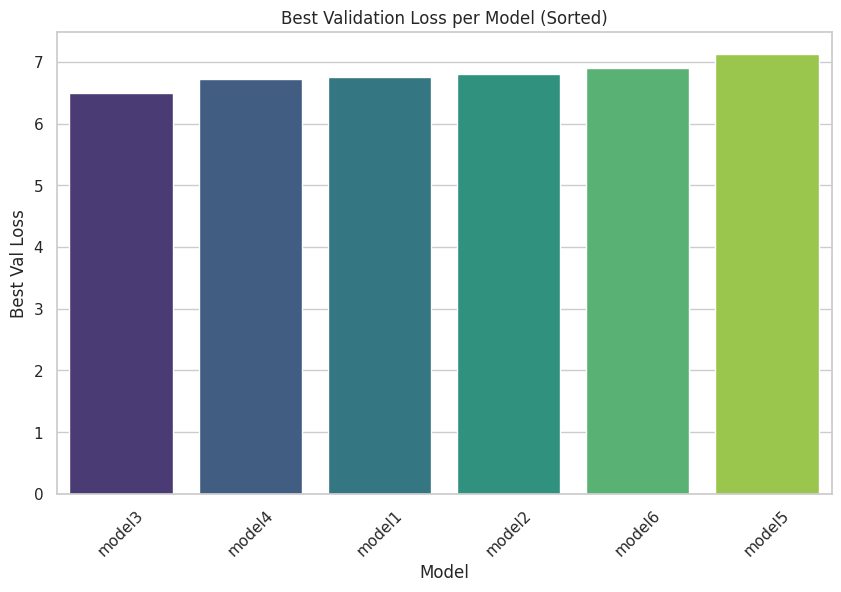

/tmp/ipykernel_132252/3768344279.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target_sorted, x='model', y=col, palette="magma")


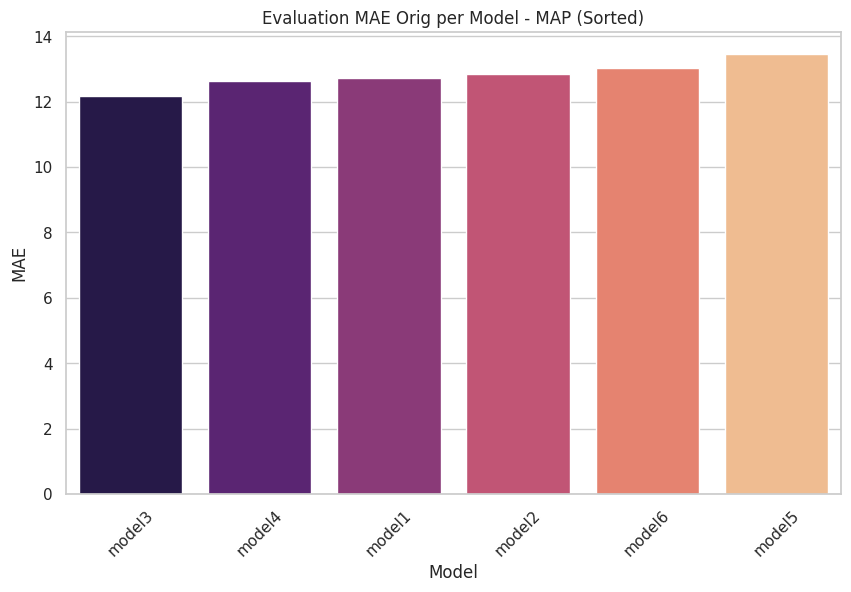

/tmp/ipykernel_132252/3768344279.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target_sorted, x='model', y=col, palette="magma")


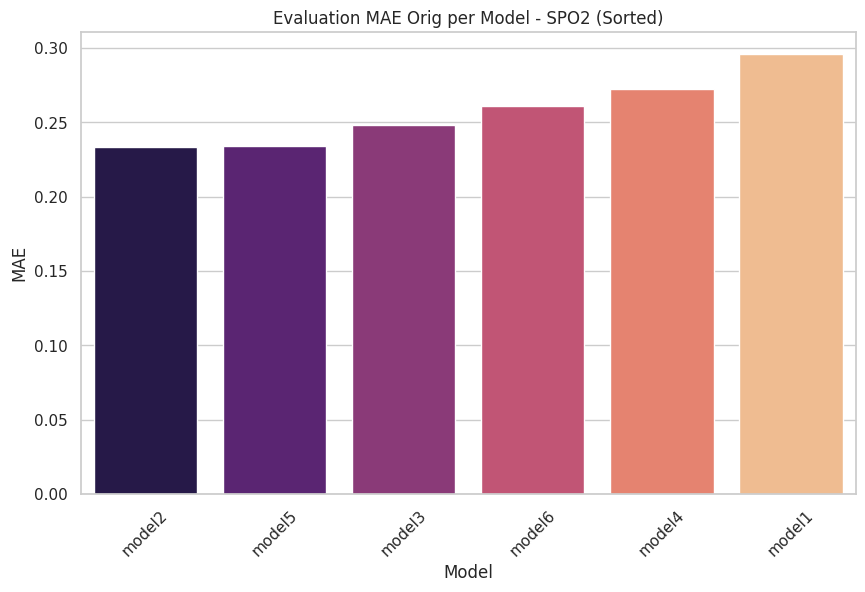

/tmp/ipykernel_132252/3768344279.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_target_sorted, x='model', y=col, palette="magma")


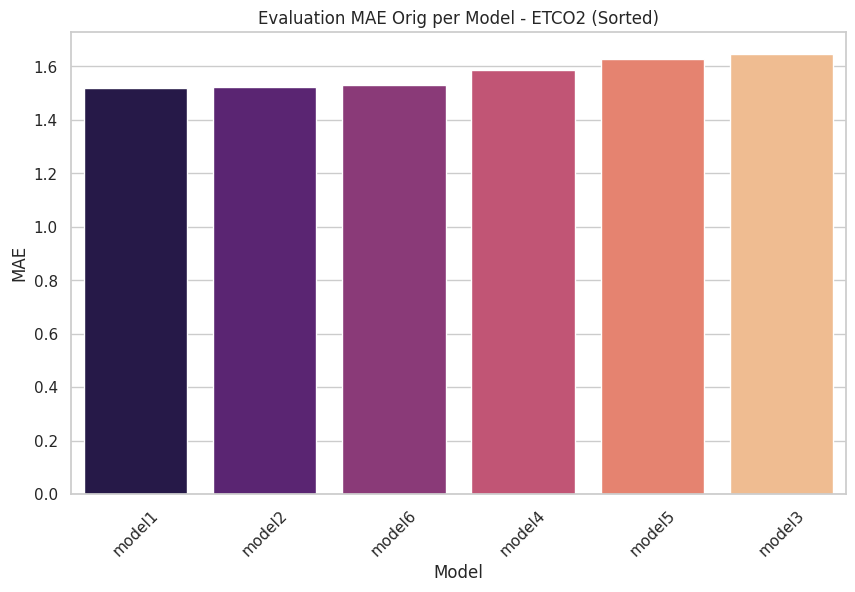

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1 Best validation loss (sorted)
df_sorted = df.sort_values(by='custom_weighted_loss', ascending=True)
plt.figure(figsize=(10,6))
sns.barplot(data=df_sorted, x='model', y='custom_weighted_loss', palette="viridis")
plt.title('Best Validation Loss per Model (Sorted)')
plt.ylabel('Best Val Loss')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# 2 Evaluation MAE for each target, sorted individually
mae_cols = ['eval_mae_0_orig', 'eval_mae_1_orig', 'eval_mae_2_orig']
target_names = ['MAP', 'SPO2', 'ETCO2']

for col, target in zip(mae_cols, target_names):
    df_target_sorted = df.sort_values(by=col, ascending=True)  # sort per target
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_target_sorted, x='model', y=col, palette="magma")
    plt.title(f'Evaluation MAE Orig per Model - {target} (Sorted)')
    plt.ylabel('MAE')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()
